#### Mettre en oeuvre le classifieur Bayesien Naif sur les données MNIST puis 20newsgroups. 

Commençons par MNIST:    
Ce corpus rassemble des images (observations) de chiffres isolés et manuscrits ainsi que les classes associées (les labels ou les réponses attendues). Il s'agit donc d'un problème de classification à 10 classes (de 0 à 9). L'objectif est d'assigner le bon chiffre à une image. 

# Chargement des données

50000 training examples


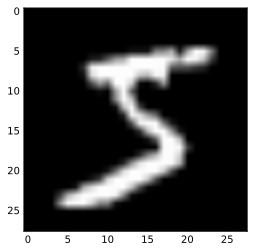

In [1]:
import cPickle, gzip
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt 
from ipywidgets import FloatProgress
from IPython.display import display

NLABELS=10
# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)

print str(len(train_set[0]))+" training examples"
f.close()
# exemple: 
im = train_set[0][0] # the first image
label = train_set[1][0] # its label

%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray)    
plt.show()

# Contenu des données


Une image est de type  <type 'numpy.ndarray'>
Ses dimensions sont :  (784,)
Threshold =  0.2
Threshold =  0.3


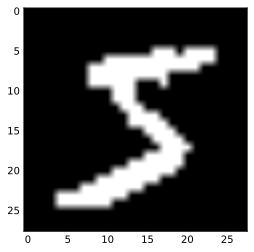

Threshold =  0.4


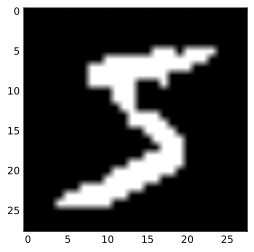

Threshold =  0.5


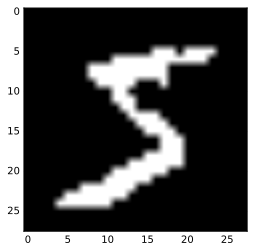

Threshold =  0.6


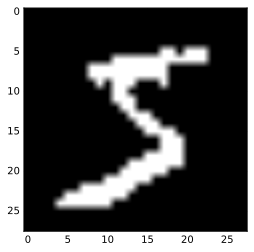

Threshold =  0.7


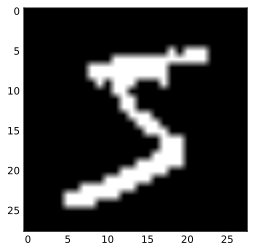

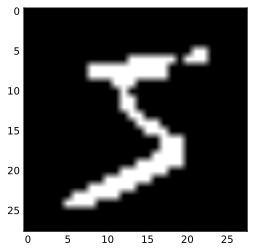

In [2]:
print "Une image est de type ",type(im)
print "Ses dimensions sont : ", im.shape

def binarizeImage(image, th=0.5):
    return 1.0*(image>threshold)
    

for threshold in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7):
    print "Threshold = ", threshold
    plt.show()
    plt.imshow(binarizeImage(im,threshold).reshape(28,28) , matplotlib.pyplot.cm.gray)    


# Manipulation des données
Voici quelques exemples de manipulation. 

In [3]:
# Récupération des images et des labels
images = train_set[0]
labels = train_set[1]
print "shape d'images  :"+str(images.shape)
print "shape de labels :"+str(labels.shape)
# les valeurs 
print "val. max  ", images.max()
print "val. min  ", images.min()
print "val. mean ", images.mean()
print "val. var  ", images.var()


# Combien y-a-t-il d'images de 5 
print "Nombre d'images dont le label est 5 :"+str((labels==5).sum())
# labels==5 retourne un ndarray de même dimension que labels mais remplit de boolean.
# True, si le label de la case est 5 et False sinon. 
# On peut se servir de cet ndarray pour faire du slicing de images
fives=images[labels==5]
print "fives contient toutes les images dont le label est 5, il y en a :"+str(fives.shape)


shape d'images  :(50000, 784)
shape de labels :(50000,)
val. max   0.996094
val. min   0.0
val. mean  0.13045
val. var   0.094427
Nombre d'images dont le label est 5 :4506
fives contient toutes les images dont le label est 5, il y en a :(4506, 784)


# Bayesien Naif (Bernoulli)
Les observations sont de nature continue. Chaque image contient 784 pixels dont la valeur est réelle et normalisée entre 0 et 1. On peut binariser ce type de données en applicant un seuil sur la valeur de chaque pixel. 

## préparation des données



In [4]:
images2 = np.zeros(images.shape)
threshold=0.3
f = FloatProgress(min=0, max=images.shape[0])
display(f)
for i in range(images.shape[0]): 
    f.value+=1
    images2[i,:]= 1.0*(images[i]>threshold)# binarizeImage(images[i],threshold)
print images2.shape

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


(50000, 784)


In [5]:
test_images2 = np.zeros(test_set[0].shape)
f = FloatProgress(min=0, max=test_set[0].shape[0])
display(f)
for i in range(test_set[0].shape[0]): 
    f.value+=1
    test_images2[i,:]= 1.0*(test_set[0][i]>threshold)# binarizeImage(images[i],threshold)
print test_images2.shape

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


(10000, 784)


50000
(784,)


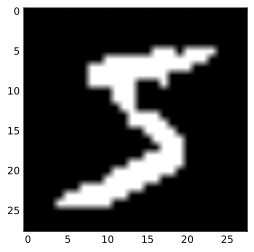

In [7]:
print len(images2)
print images2[0].shape
plt.show()
plt.imshow(images2[0].reshape(28,28) , matplotlib.pyplot.cm.gray);    


## Implémentation du Bernoulli Bayesian Naive


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


(4932, 784)


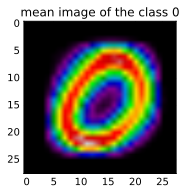

(5678, 784)


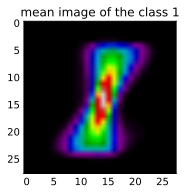

(4968, 784)


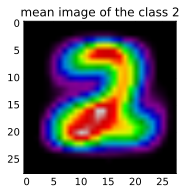

(5101, 784)


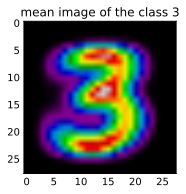

(4859, 784)


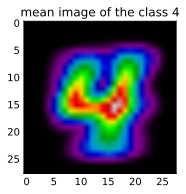

(4506, 784)


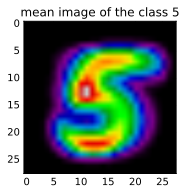

(4951, 784)


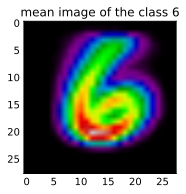

(5175, 784)


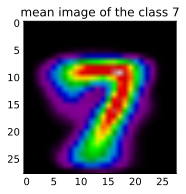

(4842, 784)


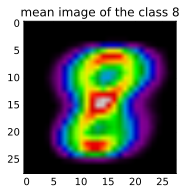

(4988, 784)


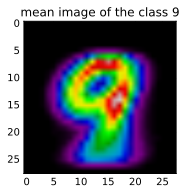

In [8]:
success = {}
f = FloatProgress(min=0, max=NLABELS)
display(f)
for lbl in range(NLABELS):
    f.value+=1
    subtrain = images2[labels==lbl]# get the subpart of train for the class
    mean = subtrain.mean(axis=0)    # compute the average rate of success
    print subtrain.shape           #        
    success[lbl]=mean                # store the mean vector in a dict 
    # plot everything
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    plt.imshow(success[lbl].reshape(28,28) , matplotlib.pyplot.cm.spectral)  
    a.set_title('mean image of the class '+str(lbl))
    matplotlib.pyplot.show()

In [9]:
priors = np.zeros([NLABELS,1])
for lbl in range(NLABELS):
    priors[lbl]=labels[labels==lbl].shape[0]
priors = priors/priors.sum()
print priors


[[ 0.09864]
 [ 0.11356]
 [ 0.09936]
 [ 0.10202]
 [ 0.09718]
 [ 0.09012]
 [ 0.09902]
 [ 0.1035 ]
 [ 0.09684]
 [ 0.09976]]


In [10]:
def computePosteriors(image, EPSILON=1e-100):
    posteriors = np.zeros([NLABELS,1])
    for lbl in range(NLABELS):
            p = success[lbl]
            logp1 = np.log(p+EPSILON)
            logp2 = np.log(1-p+EPSILON)
            llh = np.dot(image,logp1)+np.dot(1-image,logp2)
            post = llh + np.log(priors[lbl]) 
            posteriors[lbl]=post
    return posteriors
posts=computePosteriors(images2[0])
print posts
print np.argmax(posts)

[[ -283.39763033]
 [ -342.00918101]
 [ -272.26257857]
 [ -208.11220245]
 [ -525.40123595]
 [ -203.56487606]
 [-2328.46245848]
 [ -503.43938926]
 [ -226.62938304]
 [ -508.8509278 ]]
5


## évaluation du classifier 


In [11]:
tot=0.0
correct=0.0
confusion = np.zeros([NLABELS,NLABELS])

dataset=test_images2
references=test_set[1]
f = FloatProgress(min=0, max=len(dataset))
display(f)

for i in range(len(dataset)):
    f.value+=1
    posts = computePosteriors(test_images2[i],1e-100)
    hyp=np.argmax(posts)
    ref=references[i]
    if hyp==ref:
        correct+=1
    confusion[hyp][ref]+=1
    tot+=1
    if (tot%1000==0):
        print "OK : "+str(correct)+" / "+str(tot)+ " -> "+ str(correct*100/tot)+"%"  


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


OK : 821.0 / 1000.0 -> 82.1%
OK : 1601.0 / 2000.0 -> 80.05%
OK : 2406.0 / 3000.0 -> 80.2%
OK : 3213.0 / 4000.0 -> 80.325%
OK : 4007.0 / 5000.0 -> 80.14%
OK : 4893.0 / 6000.0 -> 81.55%
OK : 5771.0 / 7000.0 -> 82.4428571429%
OK : 6652.0 / 8000.0 -> 83.15%
OK : 7593.0 / 9000.0 -> 84.3666666667%
OK : 8443.0 / 10000.0 -> 84.43%


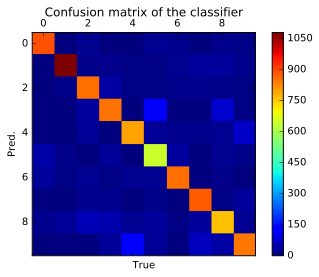

In [12]:
import pylab as pl

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
pl.xlabel('True')
pl.ylabel('Pred.')
pl.show()

## Vérification avec SKlearn


In [13]:
from sklearn.naive_bayes import  GaussianNB
clf1 = GaussianNB()
clf1.fit(train_set[0],train_set[1])

GaussianNB(priors=None)

In [14]:
print clf1.score(test_set[0],test_set[1])*100
# print clf1.score(train_set[0],train_set[1])*100

55.44


In [15]:
from sklearn.naive_bayes import BernoulliNB
clf2 = BernoulliNB()
clf2.fit(images2,train_set[1])
print clf2.score(test_images2,test_set[1])*100
print clf2.score(images2,train_set[1])*100

84.3
83.226


# Sparse data : 20newsgroups

Passons à la classification de textes. Les textes sont en effet caractérisés par des distributions (de mots) très parcimonieuses (avec beaucoup de zéros, ou *sparse* en anglais). Nous allons utiliser pour cela les données 20newsgroups. Il est disponible dans sklearn donc utilisons sklearn. 


In [16]:
from sklearn.datasets import fetch_20newsgroups
categories=None
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,)

from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(stop_words='english',binary=True)
X_train = vectorizer.transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

# test set
y_train, y_test = data_train.target, data_test.target

No handlers could be found for logger "sklearn.datasets.twenty_newsgroups"


In [17]:
print data_train.data[0]

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [18]:
print X_train.shape , X_test.shape

(11314, 1048576) (7532, 1048576)


In [19]:
clf = BernoulliNB()
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)*100
print clf.score(X_train,y_train)*100

51.3143919278
66.7756761534


In [20]:
clf = BernoulliNB(alpha = 0.)
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)*100
print clf.score(X_train,y_train)*100

/usr/local/lib/python2.7/dist-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python2.7/dist-packages/sklearn/naive_bayes.py:820: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/usr/local/lib/python2.7/dist-packages/sklearn/naive_bayes.py:823: RuntimeWarning: invalid value encountered in add
  jll += self.class_log_prior_ + neg_prob.sum(axis=1)


4.23526287839
4.24253137705


## Impact du Lissage


In [21]:
Test_score = []
Train_score = []
alphas = [0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12] 
for al in alphas: 
    clf = BernoulliNB(alpha=al)
    clf.fit(X_train,y_train)
    Test_score.append(clf.score(X_test,y_test)*100)
    Train_score.append(clf.score(X_train,y_train)*100)
    print "alpha="+str(al), clf.score(X_test,y_test)*100, clf.score(X_train,y_train)*100

alpha=0.1 71.9596388741 91.037652466
alpha=0.01 76.8852894318 96.1110129044
alpha=0.001 77.6818906001 97.5605444582
alpha=0.0001 77.9341476367 98.2411171999
alpha=1e-05 78.0801911843 98.5946614814
alpha=1e-06 78.1067445566 98.9305285487
alpha=1e-07 78.053637812 99.1073006894
alpha=1e-08 77.9075942645 99.2752342231
alpha=1e-09 77.8013807754 99.3636202934
alpha=1e-10 77.7482740308 99.4608449708
alpha=1e-11 77.7084439724 99.513876613
alpha=1e-12 77.5491237387 99.5315538271


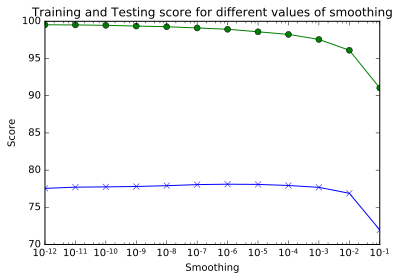

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.plot(alphas, Test_score, 'x-')
ax.plot(alphas, Train_score, 'o-')
pl.title('Training and Testing score for different values of smoothing')
pl.xlabel('Smoothing')
pl.ylabel('Score')
pl.show()    

## Classifieur multinomial


In [23]:
vectorizer_m = HashingVectorizer(stop_words='english',binary=False, norm=None, non_negative=True)
X_train_m = vectorizer_m.transform(data_train.data)
X_test_m = vectorizer_m.transform(data_test.data)

In [24]:
from sklearn.naive_bayes import MultinomialNB
Test_score = []
Train_score = []
alphas = [1., 0.5, 0.25, 0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9] 
for al in alphas: 
    clf = MultinomialNB(alpha=al)
    clf.fit(X_train_m,y_train)
    Test_score.append(clf.score(X_test_m,y_test)*100)
    Train_score.append(clf.score(X_train_m,y_train)*100)
    print "alpha="+str(al), clf.score(X_test_m,y_test)*100, clf.score(X_train_m,y_train)*100

alpha=1.0 78.7307488051 96.261269224
alpha=0.5 79.673393521 97.2335159979
alpha=0.25 80.3106744557 97.8522184904
alpha=0.1 80.5762081784 97.8610570974
alpha=0.01 80.3505045141 97.9671203818
alpha=0.001 79.673393521 98.7802722291
alpha=0.0001 79.3813064259 99.2045253668
alpha=1e-05 79.1556027616 99.4520063638
alpha=1e-06 78.8635156665 99.5757468623
alpha=1e-07 78.6510886883 99.6552943256
alpha=1e-08 78.5448751992 99.7083259678
alpha=1e-09 78.3722782793 99.7260031819


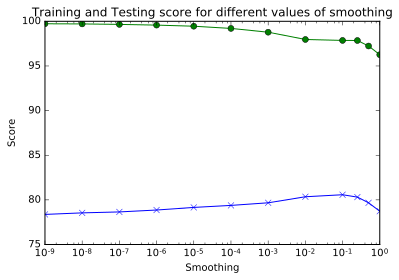

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.plot(alphas, Test_score, 'x-')
ax.plot(alphas, Train_score, 'o-')
pl.title('Training and Testing score for different values of smoothing')
pl.xlabel('Smoothing')
pl.ylabel('Score')
pl.show()   

## Impact des données


In [26]:
data_train = fetch_20newsgroups(subset='train', categories=categories, 
                                shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

X_train = vectorizer.transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

X_train_m = vectorizer_m.transform(data_train.data)
X_test_m = vectorizer_m.transform(data_test.data)

# test set
y_train, y_test = data_train.target, data_test.target

In [27]:
print data_train.data[0]

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [28]:
clfB = BernoulliNB(alpha=1e-6)
clfB.fit(X_train,y_train)
print clfB.score(X_test,y_test)*100, clfB.score(X_train,y_train)*100
clfM = MultinomialNB(alpha=0.1)
clfM.fit(X_train_m,y_train)
print clfM.score(X_test_m,y_test)*100, clfM.score(X_train_m,y_train)*100

58.4041423261 88.8898709563
63.6086032926 87.3873077603
